## Rutina General 2019

A continuación se importan las librerías necesarias para el script.

In [1]:
from __future__ import print_function, division
#Importa el modulo future, que permite la compatibilidad de versiones de Python
import sunpy.timeseries
#Importa la clase TimeSeries de la libreria Sunpy
from sunpy.net import Fido, attrs as a
#Importa la clase Fido de la libreria Sunpy
from sunpy.time import TimeRange
#Importa la clase TimeRange de la libreria Sunpy
import sunpy.data.sample
#Importa los datos de muestra de la libreria Sunpy
import sunpy.map
#Importa la funcion Map de la libreria Sunpy
from sunpy.util.metadata import MetaDict
#Importa la clase MetaDict de la libreria Sunpy
from sunpy.time import parse_time
#Importa la funcion parse_time de la libreria Sunpy
import matplotlib.pyplot as plt
%matplotlib inline
#Importa la libreria Matplolib de Python
import numpy as np
#Importa la libreria Numpy de Python
import pandas as pd
#Importa la libreria Pandas de Python
import datetime
#Importa el modulo DateTime de Python
import math
#Importa el modulo Math de Python
from glob import glob
#Importa el modulo glob de Python
import cv2 as cv
#Importa la libreria de OpenCV
import astropy.units as u
#Importa el paquete de unidades de la libreria Astropy
from astropy.time import Time
#Importa el modulo de timepo de la libreria Astropy
from astropy.table import Table
#Importa el modulo de tablas de la libreria Astropy
from astropy.io import fits
#Importa el paquete de archivos FITS de la libreria Astropy
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
#Las lineas anteriores importan el modulo de ejes 3D de la libreria Matplotlib
from skimage.feature import peak_local_max
#Importa la función peak_local_max de la libreria scikit-image

El siguiente paso corresponde a mostrar las instrucciones del script y la solicitud de un rango de tiempo para buscar en la base de datos el TimeSeries del XRS (Sensor de Rayos X).

In [3]:
#Se imprime en la terminal la información del script
print("El presente script busca y descarga los TimeSeries de las curvas XRS,\na partir de un rango de tiempo que ingresa el usuario.")
print("Seguidamente se detectan los picos en las curvas y se extraen las fechas de dichos picos.")
print("Se define un delta de tiempo y se descargan las imágenes FITS. Finalmente se estudian las\nintensidades de las imágenes FITS en una región de interés (ROI).")
print("-------------------------------------------------------------------------------------------")
print("Ingrese las fechas en cualquiera de los siguientes formatos:\n- 2007-May-04 21:08:12\n- 2007-05-04T21:08:12\n- 2007/05/04T21:08:12")
print("- 20070504T210812\n- 20070504_210812\n")
#Se le solicita el ingreso de datos al usuario
initialTime = input("Ingrese fecha inicial: ")
finalTime = input("Ingrese fecha final: ")

#Se crea el timerange con los datos ingresados por el usuario, luego se imprime
time_range = TimeRange(initialTime, finalTime)
print("\nEl intervalo de tiempo ingresado es:\n", time_range)

El presente script busca y descarga los TimeSeries de las curvas XRS,
a partir de un rango de tiempo que ingresa el usuario.
Seguidamente se detectan los picos en las curvas y se extraen las fechas de dichos picos.
Se define un delta de tiempo y se descargan las imágenes FITS. Finalmente se estudian las
intensidades de las imágenes FITS en una región de interés (ROI).
-------------------------------------------------------------------------------------------
Ingrese las fechas en cualquiera de los siguientes formatos:
- 2007-May-04 21:08:12
- 2007-05-04T21:08:12
- 2007/05/04T21:08:12
- 20070504T210812
- 20070504_210812

Ingrese fecha inicial: 2011-06-07 00:00:00
Ingrese fecha final: 2011-06-07 06:00:00

El intervalo de tiempo ingresado es:
    Start: 2011-06-07 00:00:00
    End:   2011-06-07 06:00:00
    Center:2011-06-07 03:00:00
    Duration:0.25 days or
           6.0 hours or
           360.0 minutes or
           21600.0 seconds



Lo anterior define un rango de tiempo proporsionado por el usuario. Se utiliza el objeto TimeSeries de la
librería Sunpy de Python. Cuando se imprime este objeto se observa la fecha inicial, la fecha final, el centro del intervalo y la duración en diferentes unidades.

Utilizando el TimeRange anterior, se busca y se descarga la curva del XRS. Para realizar la búsqueda se utiliza Fido.search() y se muestran los resultados de la búsqueda.

In [4]:
#Se buscan los datos con el metodo Fido.search(), se le pasa el intervalo de tiempo ingresado
resultSearchXRS = Fido.search(a.Time(time_range.start, time_range.end), a.Instrument('XRS'))
#Se muestra el resultado de la busqueda
resultSearchXRS

Start Time,End Time,Source,Instrument,Wavelength
str19,str19,str4,str4,str3
2011-06-07 00:00:00,2011-06-07 23:59:59,nasa,goes,nan


Se procede a descarga los datos de la curva. Se descargan los datos utilizando Fido.fetch() y se guardan en el path especificado.

In [5]:
#Se descargan los datos de la curva con el metodo Fido.fetch()
filesXRS = Fido.fetch(resultSearchXRS, path='DatosJupyterSun/CurvasXRS')

Ahora se crea un objeto TimeSeries, el cual contiene los datos descargados anteriormente, y se plotea.

/home/gabriel/anaconda3/envs/solar/lib/python3.6/functools.py:807: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/gabriel/anaconda3/envs/solar/lib/python3.6/asyncio/base_events.py:516: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/gabriel/anaconda3/envs/solar/lib/python3.6/asyncio/selector_events.py:630: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=49>
  source=self)


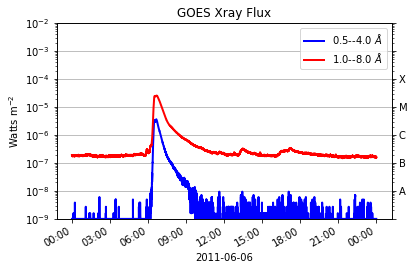

In [6]:
#Se crea un objeto TimeSeries con los datos descargados
goesXRS_TS = sunpy.timeseries.TimeSeries(filesXRS, source= 'XRS')
#Se plotea la curva
goesXRS_TS.peek()

Se obtienen dos curvas, de las cuales se tomará la roja, que corresponde a los datos "xrsb". A esa curva se le deben encontrar los picos máximos. Para esto se utiliza la función findpeaks(series,Delta), la cual recibe los datos de una serie y un valor que corresponde a la sensibilidad.

In [7]:
#Se declara la funcion findpeaks, recibe como parametros los datos de la curva y una constante
def findpeaks(series, DELTA):
    # Se declaran los valores iniciales; dos infinitos, dos listas vacias y dos booleanos
    mn, mx = np.Inf, -np.Inf
    minpeaks = []
    maxpeaks = []
    lookformax = True
    start = True
    #Se itera sobre cada uno de los elementos en la serie
    #Se usa un ciclo for para tomar el valor de la serie que se itera
    for time_pos, value in series.iteritems():
    #Se usa un if que compara si el valor de la iteracion es mas grande que el declarado al inicio, si 
    #lo es, se sobreescribe el valor y se guarda la posición del maximo en mxpos 
        if value > mx:
            mx = value
            mxpos = time_pos
    #Este if funciona igual que el anterior, solo que compara los valores minimos en lugar de los maximos
        if value < mn:
            mn = value
            mnpos = time_pos
    #En este if se entra si la variable lookformax vale True
        if lookformax:
    #Se usa un if para comparar si el valor de la serie durante la iteracion es menor al valor maximo,
    #declarado al inicio, mas la constante recibida por la funcion. Si esto se cumple, se guardan los
    #valores de mx y mxpos obtenidos en los if's anteriores en la lista vacia declarada al principio
    #y cambia a False lookformax
            if value < mx-DELTA:
                # un maximo local
                maxpeaks.append((mxpos, mx))
                mn = value
                mnpos = time_pos
                lookformax = False
    #El elif se encarga de guardar los valores de mnpos y mn en la lista vacia.
            elif start:
                # un minimo local al principio
                minpeaks.append((mnpos, mn))
                mx = value
                mxpos = time_pos
                start = False
    #El if y el elif anteriores estan identados dentro del if de lookformax; el siguiente else es el 
    #que le corresponde
        else:
    #Se usa un if para compara si el valor de la serie de la iteracion es mayor que el valor minimo,
    #declarado al principio, mas la constante recibida por la funcion. Se guardan los valores minimos
    #en la lista vacia
            if value > mn+DELTA:
                # minimo local
                minpeaks.append((mnpos, mn))
                mx = value
                mxpos = time_pos
                lookformax = True
    
    # Se vuelve a revisar los valores minimos y maximos
    if value > mn+DELTA:
        maxpeaks.append((mxpos, mx))
    elif value < mx-DELTA:
        minpeaks.append((mnpos, mn))
    return minpeaks, maxpeaks

A continuación, se extraen los datos de la curva roja para pasarlos a la función findpeaks. El resultado se 
guarda en una arreglo, se imprime como un objeto DataFrame y se plotean los puntos encontrados sobre la figura.

Los picos máximos son:
                              0             1
0 2011-06-07 06:30:57.441999912  2.456800e-05
1 2011-06-07 06:32:52.128999949  2.448400e-05
2 2011-06-07 06:33:51.518999934  2.450500e-05
3 2011-06-07 06:39:11.001999855  2.546000e-05
4 2011-06-07 06:41:24.118999958  2.555400e-05
5 2011-06-07 13:28:05.584999919  3.224900e-07
6 2011-06-07 17:12:10.468999863  3.434800e-07


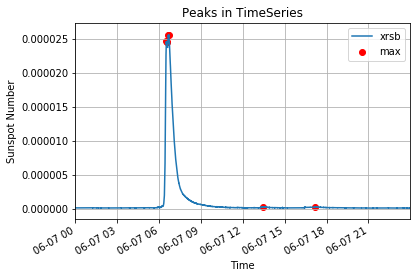

In [8]:
#Se extrae la serie xrsb, la serie roja
xrs_Series = goesXRS_TS.data['xrsb']

#Se extraen los picos mínimos y máximos de la serie utilizando la funcion findpeaks
min_picos, max_picos = findpeaks(xrs_Series, DELTA=0.0000001)

#Se imprimen los picos máximos encontrados 
print ('Los picos máximos son:')
print (pd.DataFrame(max_picos))


#Se plotea la curva con los picos máximos utilizando los metodos de la libreria Matplotlib
plt.figure() #Crea la figura
plt.ylabel('Sunspot Number') #Etiqueta el eje y
plt.xlabel('Time') #Etiqueta el eje x
plt.title('Peaks in TimeSeries') #Pone el titulo de la imagen
xrs_Series.plot() #Plotea la curva
plt.scatter(*zip(*max_picos), color='red', label='max') #Punto de color rojo en máximos
plt.legend() #Activa la leyenda en la imagen
plt.grid(True) #Activa la cuadricula en la imagen 
plt.show() #Muestra la figura

Se necesita descartar los picos que sea menores a $10^{-6}$, se imprimen nuevamente como un DataFrame y vuelven a plotear los puntos sobre la curva.

Los picos máximos por encima de 1x10^(-6) son: 

                              0         1
0 2011-06-07 06:30:57.441999912  0.000025
1 2011-06-07 06:32:52.128999949  0.000024
2 2011-06-07 06:33:51.518999934  0.000025
3 2011-06-07 06:39:11.001999855  0.000025
4 2011-06-07 06:41:24.118999958  0.000026


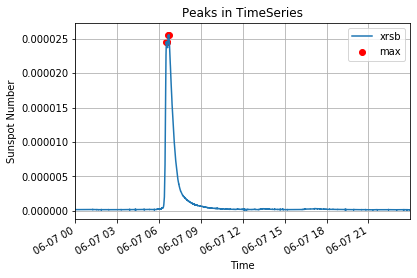

In [9]:
#Se declara una lista vacia donde se guardarán los picos mayores a 1x10^(-6)
maxPicosArriba10e_m06 = []

#Se recorre y se revisa la lsita donde se habian guardado los valores maximos
for i in range(0, len(max_picos)-1):
    if max_picos[i][1] > 1.0e-06:
        maxPicosArriba10e_m06.append(max_picos[i])
    
#Se imprimen picos por encima del limite establecido
print ('Los picos máximos por encima de 1x10^(-6) son: \n')
print (pd.DataFrame(maxPicosArriba10e_m06))

#Se plotea la curva con los picos máximos, volviendo a usar la libreria Matplotlib
plt.figure() #Crea la figura
plt.ylabel('Sunspot Number') #Etiqueta el eje y
plt.xlabel('Time') #Etiqueta el eje x
plt.title('Peaks in TimeSeries') #Pone el titulo de la imagen
xrs_Series.plot() #Plotea la curva
plt.scatter(*zip(*maxPicosArriba10e_m06), color='red', label='max') #Punto de color rojo en máximos
plt.legend() #Activa la leyenda en la imagen
plt.grid(True) #Activa la cuadricula en la imagen 
plt.show() #Muestra la figura

Cuando los picos son identificados, se guardan en una archivo .csv mediante la utilización de pandas.

In [10]:
#Se define DataFrame de pandas para guardar información en archivo .csv
dataFrameMaxPicos = pd.DataFrame(maxPicosArriba10e_m06)
dataFrameMaxPicos.to_csv('DatosJupyterSun/maxPicos.csv', sep='\t', index=False)

A continuación se define la función returnDataRange(centralDate, delta_min), la cual toma las fechas de los picos máximos detectados en las curvas, y crea un rango de tiempo con un delta_min = 30 min antes y después.


In [11]:
#Define un TimeRange de una hora, a partir de la hora central extraídaen la curva XRS. 
#Con el TimeRange se busca en la base de datos JSOC los archivos FITS
def returnDataRange(centralDate, delta_min):
    #Se declara el inicio del rango de tiempo con TimeRange().previous() y el final
    #con TimeRange y se retorna
    date_rangeUp = TimeRange(centralDate, delta_min * u.min).previous()
    date_rangeFinal = TimeRange(date_rangeUp.start, date_rangeUp.next().end)
    return date_rangeFinal

#Se define el TimeRange, a partir de un pico máximo
maxPicoTR = returnDataRange(maxPicosArriba10e_m06[4][0], 30) #Se llama al funcion returnDataRange
print (maxPicoTR) #Se imprime el intervalo de tiempo

    Start: 2011-06-07 06:11:24
    End:   2011-06-07 07:11:24
    Center:2011-06-07 06:41:24
    Duration:0.04166666666666674 days or
           1.0000000000000018 hours or
           60.00000000000011 minutes or
           3600.0000000000064 seconds



/home/gabriel/anaconda3/envs/solar/lib/python3.6/functools.py:807: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


Se necesita obtener un rango de tiempo de los picos, para lo cual se utiliza la función returnDataRange(centralDate, delta_min),
que toma la fecha de los picos con un delta de tiempo de 30 minutos antes y después.

In [12]:
#Se buscan los datos que corresponden a la serie aia.lev1, se usa una cadencia de 12 segundos y 
#una longitud de onda de 193 Ångström. Estos datos se buscan utilizando el rango de tiempo
#encontrado anteriormente. Una vez completada la busqueda, se despliega el resultado
resultsAIA = Fido.search(a.Time(maxPicoTR.start, maxPicoTR.end), a.jsoc.Series('aia.lev1_euv_12s'), a.jsoc.Wavelength(193*u.AA), a.vso.Sample(2*u.minute),  a.jsoc.Notify('yasser.wagon@ucr.ac.cr'))
resultsAIA

T_REC,TELESCOP,INSTRUME,WAVELNTH,CAR_ROT
str20,str7,str5,int64,int64
2011-06-07T06:11:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:13:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:15:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:17:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:19:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:21:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:23:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:25:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:27:26Z,SDO/AIA,AIA_2,193,2111


Se procede a descargar los archivos FITS

In [14]:
#Se procede a descargar los archivos FITS resultantes de la busqueda
downloaded_files = Fido.fetch(resultsAIA, path='DatosJupyterSun/JSOC_AIA_FITS/{file}.fits')

Export request pending. [id="JSOC_20190604_919", status=2]
Waiting for 0 seconds...
62 URLs found for download. Full request totalling 363MB


Ahora, se debe abrir el archivo FITS para convertirlo en un objeto map de Sunpy.

/home/gabriel/anaconda3/envs/solar/lib/python3.6/asyncio/base_events.py:516: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)


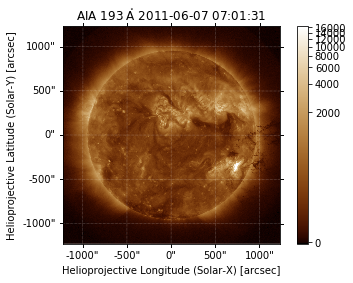

In [15]:
#Se abre archivo FITS y se convierte a un objeto map de sunpy
fits_image_filename = 'DatosJupyterSun/JSOC_AIA_FITS/aia.lev1_euv_12s.2011-06-07T070133Z.193.image_lev1.fits'

aiamap = sunpy.map.Map(fits_image_filename) 
aiamap1 = sunpy.map.Map(fits_image_filename)
#Las lineas anteriores crean los objetos map de la libreria Sunpy

plt.figure() #Crea la figura
aiamap.plot() #Plotea los datos
plt.colorbar() #Plotea la barra de intensidad

Se delimita la zona de interés con un cuadro de lado igual a (2)(0.75*R_SUN) y centrado en el disco solar. Para ello se ingresa al metadata del map y se extraen las coordenadas en pixeles del sol, además del radio, y se guardan en variables.

In [16]:
crpix1 = int(aiamap.meta['CRPIX1']) 
crpix2 = int(aiamap.meta['CRPIX2'])
#Las lineas anteriores extraen los datos de los pixeles del sol. La linea siguiente es el radio
rSun = int(aiamap.meta['R_SUN'])
sunCenter = np.array([crpix1, crpix2]) 

#Se imprimen los datos
print('El centro del disco solar está en el punto: ', sunCenter, 'pixel')
print ('El radio del sol en pixeles es: ', rSun, 'pixeles')

El centro del disco solar está en el punto:  [2044 2048] pixel
El radio del sol en pixeles es:  1574 pixeles


Se define la función, drawROI(sunImageData, sunCenter, pixRadius, proportion), que se encargará de dibujar un cuadro que delimitará la ROI.

In [17]:
def drawROI(sunImageData, sunCenter, pixRadius, proportion):
    propRadius = int(proportion * pixRadius)
#    cv.rectangle(sunImageData, (sunCenter[0] - propRadius, sunCenter[1] - propRadius), (sunCenter[0] + propRadius, sunCenter[1] + propRadius), 0, 30)
    cv.circle(sunImageData, (sunCenter[0], sunCenter[1]), propRadius, 0, 30, cv.LINE_AA)
    #Se crea el circulo en la imagen con el metodo circle de OpenCV y se retorna
    return sunImageData

Se dibuja el ROI sobre el map del archivo FITS abierto y se gráfica.

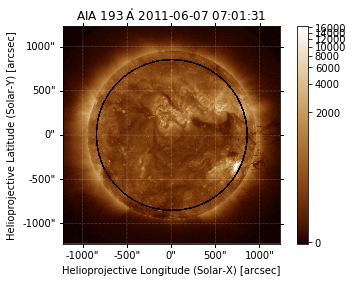

In [18]:
drawROI(aiamap.data, sunCenter, rSun, 0.90) #Se llama a la funcion para deibujar el ROI
plt.figure() #Se crea la figura
aiamap.plot() #Plotea los datos
plt.colorbar() #Plotea la barra de intensidad

Deben ubucarse los picos de alta intensidad en el mapa; para esto se utiliza la función peak_local_max(). Se debe definir los pixeles de alta intensidad, los que sean al menos un 80% del pixel más intenso.

In [19]:
#Se ubican los picos de intensidad con la funcion peak_local_max de scikit-image
coorPicos = peak_local_max(aiamap.data, min_distance=200, threshold_rel=0.2)
print('Los puntos de alta intensidad en el map son: \n') #Se imprime el mensaje
print (pd.DataFrame(coorPicos)) #Se imprimen los picos de intensidad en forma de DataFrame de Pandas

Los puntos de alta intensidad en el map son: 

      0     1
0  2524  3361
1  2517  2949
2  2365   493
3  2330  1846
4  2295  2360
5  1482  3256


Ahora se deben marcar los picos de alta intensidad en el mapa.

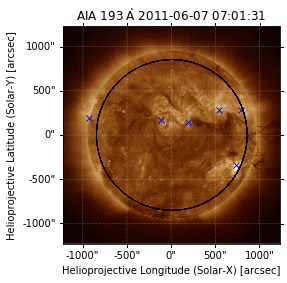

In [20]:
hpc_max = aiamap.pixel_to_world(coorPicos[:, 1]*u.pixel, coorPicos[:, 0]*u.pixel)
fig = plt.figure() #Crea la figura
ax = plt.subplot(projection=aiamap) 
aiamap.plot() #Plotea los datos
ax.plot_coord(hpc_max, 'bx') #Plotea los puntos de intensidad
plt.show() #Muestra la figura

Deben descartarse los picos que estén fuera del ROI, para eso es la función picosROI().

In [21]:
def picosROI(coordenadasPicos, sunCenter, pixRadius, prop):
    propRadius = int(prop * pixRadius)
    picosEnROI = []
    picosEnROICircular = []
    for l in range(0, len(coordenadasPicos)-1):
        r_peak = math.sqrt(((coordenadasPicos[l][0]-sunCenter[0])**2) + ((coordenadasPicos[l][1]-sunCenter[1])**2))
        if (r_peak < propRadius):
            picosEnROICircular.append(coordenadasPicos[l])
        
        
    for s in range(0, len(coordenadasPicos)-1):
        if (coordenadasPicos[s][0] > sunCenter[0] - propRadius and coordenadasPicos[s][0] < sunCenter[0] + propRadius):
            if(coordenadasPicos[s][1] > sunCenter[1] - propRadius and coordenadasPicos[s][1] < sunCenter[1] + propRadius):
                picosEnROI.append(coordenadasPicos[s])
                
    return np.array(picosEnROI), np.array(picosEnROICircular)

Ahora se ubican los pricos de alta intensidad y marcan en el mapa.

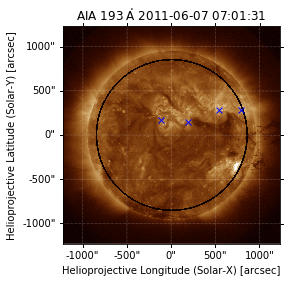

In [22]:
#Se ubican los picos de alta intensidad dentro del ROI 
picosen_roi, picosCircu = picosROI(coorPicos, sunCenter, rSun, 0.90)
#Se dibuja ROI en map
drawROI(aiamap.data, sunCenter, rSun, 0.90)
#Se mapean las coordenadas en el map
hpc_max1 = aiamap1.pixel_to_world(picosen_roi[:, 1]*u.pixel, picosen_roi[:, 0]*u.pixel)
hpc_max2 = aiamap1.pixel_to_world(picosCircu[:, 1]*u.pixel, picosCircu[:, 0]*u.pixel)

#Se grafica la imagen con los picos de alta intensidad dentro del ROI, marcados con una equis azul
fig = plt.figure()
ax = plt.subplot(projection=aiamap)
aiamap.plot()
ax.plot_coord(hpc_max2, 'bx')
plt.show()


La función guardar3DPlotROI() se encarga de realizar un gráfico en 3D del ROI, para cada uno de los archivos FITS de la carpeta que se le índique. La función tiene como entrada el path del directorio donde estarán contenidos los archivos FITS, la ubicación de los picos de alta intensidad dentro del ROI, el centro del sol, el radio y la proporción del ROI con respecto al disco solar.

In [23]:
def guardar3DPlotROI(FITS_dirPath, picosEnROI, sunCenter, pixRadius, prop):
    #Se obtienen las direcciones de los archivos FITS a gráficar
    fitsPaths= sorted(glob(str(FITS_dirPath)+'/*193.image_lev1.fits'))
    print (len(fitsPaths))
    
     # Se itera sobre cada archivo FITS del directorio
    for i in range(0, len(fitsPaths)):
        # Se crea objeto Map y se obtiene el centro(sunC) y radio(radiusSun) 
        # del disco solar de los metadatos 
        aiamapFITS_i = sunpy.map.Map(fitsPaths[i])
        propRadius = int(prop * pixRadius)
        
        x = np.arange(aiamapFITS_i.data.shape[0])
        y = np.arange(aiamapFITS_i.data.shape[1])
        X, Y = np.meshgrid(x[int(sunCenter[0]-propRadius): int(sunCenter[0]+propRadius)], y[int(sunCenter[1]-propRadius): int(sunCenter[1]+propRadius)])
    
    time_obs = str(aiamapFITS_i.meta['date-obs'])
    if('.84' in time_obs):  
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, aiamapFITS_i.data[int(sunCenter[0]-propRadius): int(sunCenter[0]+propRadius), int(sunCenter[1]-propRadius): int(sunCenter[1]+propRadius)])
        ax.set_zlim(0, 8000)    
        ax.view_init(elev=39, azim=64)
        peaks_pos = aiamapFITS_i.data[picosEnROI[:, 0], picosEnROI[:, 1]]
        ax.scatter(picosEnROI[:, 1], picosEnROI[:, 0], peaks_pos, color='r')
        ax.set_xlabel('X Coordinates')
        ax.set_ylabel('Y Coordinates')
        ax.set_zlabel('Intensity')
        
        plt.savefig('DatosJupyterSun/3D')
        plt.close(fig)

In [51]:
from matplotlib.patches import Circle, PathPatch
def guardar3DPlotROI2(FITS_dirPath, picosEnROI, sunCenter, pixRadius, prop):
    import mpl_toolkits.mplot3d.art3d as art3d
    #Se obtienen las direcciones de los archivos FITS a gráficar
    fitsPaths= sorted(glob(str(FITS_dirPath)+'/*193.image_lev1.fits'))
    print (len(fitsPaths))
    
     # Se itera sobre cada archivo FITS del directorio
    for i in range(0, len(fitsPaths)):
        # Se crea objeto Map y se obtiene el centro(sunC) y radio(radiusSun) 
        # del disco solar de los metadatos 
        aiamapFITS_i = sunpy.map.Map(fitsPaths[i])
        propRadius = int(prop * pixRadius)
        
        x = np.arange(aiamapFITS_i.data.shape[0])
        y = np.arange(aiamapFITS_i.data.shape[1])
        X, Y = np.meshgrid(x[int(sunCenter[0]-propRadius): int(sunCenter[0]+propRadius)], y[int(sunCenter[1]-propRadius): int(sunCenter[1]+propRadius)])
    
    time_obs = str(aiamapFITS_i.meta['date-obs'])
    if('.84' in time_obs):  
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111, projection='3d')
        p = Circle((x[int(sunCenter[0]-propRadius)], y[int(sunCenter[1]-propRadius)]), propRadius)
        ax.add_patch(p)
        art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")
        ax.plot_surface(X, Y, aiamapFITS_i.data[int(sunCenter[0]-propRadius): int(sunCenter[0]+propRadius), int(sunCenter[1]-propRadius): int(sunCenter[1]+propRadius)])
        ax.set_zlim(0, 8000)    
        ax.view_init(elev=39, azim=64)
        peaks_pos = aiamapFITS_i.data[picosEnROI[:, 0], picosEnROI[:, 1]]
        ax.scatter(picosEnROI[:, 1], picosEnROI[:, 0], peaks_pos, color='r')
        ax.set_xlabel('X Coordinates')
        ax.set_ylabel('Y Coordinates')
        ax.set_zlabel('Intensity')
        #ax.view_init(elev=20., azim=-35)
        
        plt.savefig('DatosJupyterSun/3D')
        #plt.close(fig)  
    

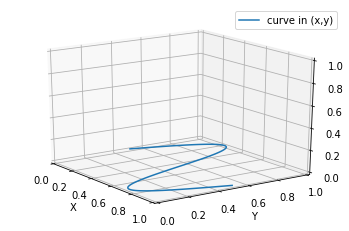

In [39]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot a sin curve using the x and y axes.
x = np.linspace(0, 1, 100)
y = np.sin(x * 2 * np.pi) / 2 + 0.5
ax.plot(x, y, zs=0, zdir='z', label='curve in (x,y)')

# Make legend, set axes limits and labels
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=-35)

plt.show()

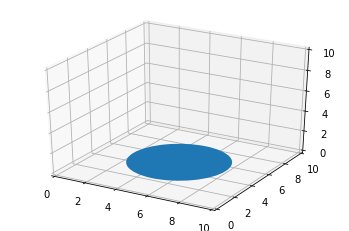

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import mpl_toolkits.mplot3d.art3d as art3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Draw a circle on the x=0 'wall'
p = Circle((5, 5), 3)
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_zlim(0, 10)

plt.show()


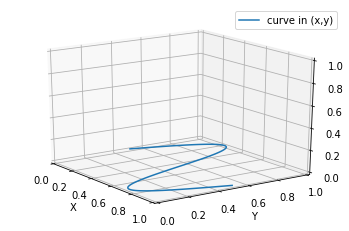

In [41]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot a sin curve using the x and y axes.
x = np.linspace(0, 1, 100)
y = np.sin(x * 2 * np.pi) / 2 + 0.5
ax.plot(x, y, zs=0, zdir='z', label='curve in (x,y)')

ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=-35)

plt.show()

Se realiza el gráfico 3D para los archivos FITS que se descargaron antes.

31


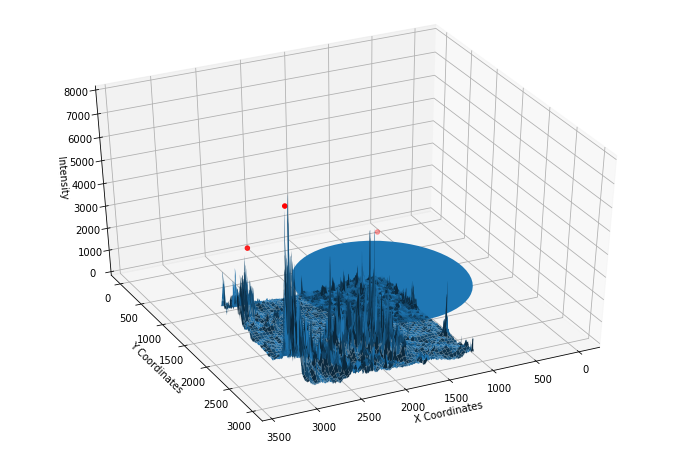

In [52]:
#Se define en una variable el path del directorio
fitsDir = 'DatosJupyterSun/JSOC_AIA_FITS'
#Se llama a la función guardar3DPlotROI, para generar las gráficas
guardar3DPlotROI2(fitsDir, picosCircu, sunCenter, rSun, 0.6)

Con los picos de alta intensidad identificados en los maps, se procede a realizar el registro de las intensidades a través del tiempo. Se define la función obtenerIntensidadesDePicosROI() que recorrerá los archivos FITS y extraerá las intensidades de los picos dentro del ROI. Se retorna una matriz con la información.

In [84]:
def obtenerIntensidadesDePicosROI (FITS_dirPath, picosEnROI):
    #Se obtiene el path de los archivos FITS contenidos en el directorio
    fitsPaths= sorted(glob(str(FITS_dirPath)+'/*193.image_lev1.fits'))
    matrix = [['Time']]
    
    #Se ingresa la coordenada de los picos de alta intensidad en las columnas de la
    #fila cero.
    for k in range(0, len(picosEnROI)):
        matrix[0].append(picosEnROI[k])
    
    #Se itera sobre los archivos FITS y se extrae la intensidad
    for i in range(0, len(fitsPaths)):
        aiamapFITS_i = sunpy.map.Map(fitsPaths[i])
        row_i = []
        time_obs = str(aiamapFITS_i.meta['date-obs'])
        if('.84' in time_obs):
            row_i.append(parse_time(time_obs))            
            peaks_pos = aiamapFITS_i.data[matrix[]]
            for s in range(0, len(peaks_pos)):
                row_i.append(peaks_pos[s])
            
            matrix.append(row_i)
        
        
    return np.array(matrix)           
            

Se obtienen las intensidades de los picos de los maps y se imprime.


In [85]:
matriz = obtenerIntensidadesDePicosROI(fitsDir, picosCircu)
pd.DataFrame(matriz).to_csv('DatosJupyterSun/maxPicosEvolucion.csv', sep='\t', index=False)
print (pd.DataFrame(matriz, index=None, columns=None))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Se crea un TimeSeries con la matriz anterior y se gráfica para ver la evolución de los picos en el tiempo.

In [86]:
tsROI = sunpy.timeseries.TimeSeries(pd.DataFrame(matriz[1:][1:], index=None, columns=None))
tsROI.peek()

TypeError: 'NoneType' object is not subscriptable

La fucnión arrayMaps() se encarga de mostrar la imágenes en un array para observalas de manera secuencial

In [ ]:
def arrayMaps(FITS_dirPath):
    fitsPaths= sorted(glob(str(FITS_dirPath)+'/*193.image_lev1.fits'))
    img = []
    
    fig = plt.figure(figsize=(40,40))
    for i in range(0, len(fitsPaths)):
        aiamapFITS_i = sunpy.map.Map(fitsPaths[i])
        time_obs = str(aiamapFITS_i.meta['date-obs'])
        if('.84' in time_obs):
            fig.add_subplot(4, 8, i+1)
            aiamapFITS_i.plot()

        
    plt.show()

Se llama a la función arrayMaps para graficar los archivos FITS

In [ ]:
#Se envían los archivos FITS para que se grafiquen en un arreglo
arrayMaps(fitsDir)

La función convert_frames_to_video() se encarga de tomar los frames de las imágenes en 3D del ROI y genera un vídeo para observar mejor la dinámica de los pixeles en la región de interes.


In [ ]:
def convert_frames_to_video(pathIn,pathOut,fps):    
    frame_array = []
    files = sorted(glob(str(pathIn)+'/*.png'))
 
    #for sorting the file names properly
    
    for i in range(len(files)):
        filename=files[i]
        #reading each files
        img = cv.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv.VideoWriter(pathOut,cv.VideoWriter_fourcc(*'DIVX'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

In [ ]:
#Se define el path del directorio donde están contenidas las imágenes 3D
pathIn = 'DatosJupyterSun/3D'
#Se define el path donde se guardará el video
pathOut = 'DatosJupyterSun/video.avi'
#Es posible ajustar los fotogramas por segundo(fps) del vídeo
fps = 3.0
#Se genera el vídeo con las variables definidas anteriormente
convert_frames_to_video(pathIn, pathOut, fps)